In [1]:
#@tile Requirements

!pip install tensorflow -q

In [37]:
#@title Packages

import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, Huber
from tensorflow.keras.backend import sqrt, mean, square
from tensorflow.keras import backend as K

In [38]:
#@tile Read and Prepare Data

def read_prepare_data(symbol):
    #read
    data = pd.read_csv('/Users/pedroalexleite/Desktop/Tese/Dados/dataset4.csv')
    train =  pd.read_csv('/Users/pedroalexleite/Desktop/Tese/Dados/train.csv')
    test =  pd.read_csv('/Users/pedroalexleite/Desktop/Tese/Dados/test.csv')
    
    #we're going to use only one symbol
    data = data[data['Symbol'] == symbol].copy()
    train = train[train['Symbol'] == symbol].copy()
    test = test[test['Symbol'] == symbol].copy()
    
    #we're going to use only the price variable
    data = data[['Date', 'Close']].copy()
    train = train[['Date', 'Close']].copy()
    test = test[['Date', 'Close']].copy()
    
    #set date as index
    data.set_index('Date', inplace=True)
    train.set_index('Date', inplace=True)
    test.set_index('Date', inplace=True)

    #normalize
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
    test = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index) 

    return scaler, data, train, test

scaler, data, train, test = read_prepare_data('AAPL')

#verify
print(data.head())
print(data.index)   
print(data.columns)

               Close
Date                
2021-11-01 -0.329693
2021-11-02 -0.300014
2021-11-03 -0.258855
2021-11-04 -0.273695
2021-11-05 -0.264735
Index(['2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05',
       '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10',
       ...
       '2024-10-23', '2024-10-24', '2024-10-25', '2024-10-26', '2024-10-27',
       '2024-10-28', '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01'],
      dtype='object', name='Date', length=1097)
Index(['Close'], dtype='object')


In [39]:
#@title Create Dataset

def create_dataset(dataframe, look_back):
    dataset = dataframe.values
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

In [40]:
#@title Reshape

def reshape(train, test, look_back):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

    return trainX, trainY, testX, testY

In [41]:
#@title Forecast

def LSTM_forecast(testY, look_back, horizon, model):
    testY_copy = testY.copy()
    for val in range(0, horizon+1):
        a = testY_copy[-(1+look_back):-1]
        a = np.reshape(a, (1, look_back, 1)) 
        a_predict = model.predict(a, verbose=0)[0]
        a_predict = np.reshape(a_predict, (1, 1))
        testY_copy = np.concatenate((testY_copy, a_predict), axis=0)
    
    forecast = testY_copy[len(testY):]
    return forecast

In [42]:
#@title Auxiliary Function for the LSTMs

def predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model):
    #make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    #forecast
    forecast = LSTM_forecast(testY, look_back, horizon, model)

    #invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    forecast = scaler.inverse_transform(forecast)

    #calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

    #plot predictions
    if plot_predictions==True: 
        #shift train predictions for plotting
        trainPredictPlot = np.empty_like(data)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        
        #shift test predictions for plotting
        testPredictPlot = np.empty_like(data)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
        
        #shift forecast for plotting
        forecastPlot = np.empty_like(pd.concat([data, pd.DataFrame(forecast)]))
        forecastPlot[:, :] = np.nan
        forecastPlot[len(data):len(forecastPlot),:] = forecast
        
        #plot baseline, predictions and forecast
        plt.figure(figsize=(15,7))
        plt.plot(scaler.inverse_transform(data), label='real')
        plt.plot(trainPredictPlot, label='train set prediction')
        plt.plot(testPredictPlot, label='test set prediction')
        plt.plot(forecastPlot, label='forecast')
        plt.legend()
        plt.show()

    return testScore

In [9]:
#@title LSTM Models

def LSTM_models(look_back, trainX):
    layers = [1, 2, 3]
    neurons = [2, 4, 8, 16]
    dropouts = [0.1, 0.2]
    models = []
    configurations = []
    
    for num_layers in layers:
        for num_neurons in neurons:
            for dropout_rate in dropouts:
                model = Sequential()

                model.add(LSTM(num_neurons, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=(num_layers > 1)))
                model.add(Dropout(dropout_rate))
                
                for layer_idx in range(1, num_layers):
                    model.add(LSTM(num_neurons, return_sequences=(layer_idx < num_layers - 1)))
                    model.add(Dropout(dropout_rate))
                
                model.add(Dense(1))
                
                model.compile(loss='mean_squared_error', optimizer='adam')
                
                models.append(model)
                configurations.append({
                    "layers": num_layers,
                    "neurons": num_neurons,
                    "dropout": dropout_rate
                })
    
    return models, configurations


look_back = 10
trainX, trainY, testX, testY = reshape(train, test, look_back)
models, configurations = LSTM_models(look_back, trainX)

print("Configurations:")
for idx, config in enumerate(configurations, start=1):
    print(f"Model {idx}: Layers={config['layers']}, Neurons={config['neurons']}, Dropout={config['dropout']}")

Configurations:
Model 1: Layers=1, Neurons=2, Dropout=0.1
Model 2: Layers=1, Neurons=2, Dropout=0.2
Model 3: Layers=1, Neurons=4, Dropout=0.1
Model 4: Layers=1, Neurons=4, Dropout=0.2
Model 5: Layers=1, Neurons=8, Dropout=0.1
Model 6: Layers=1, Neurons=8, Dropout=0.2
Model 7: Layers=1, Neurons=16, Dropout=0.1
Model 8: Layers=1, Neurons=16, Dropout=0.2
Model 9: Layers=2, Neurons=2, Dropout=0.1
Model 10: Layers=2, Neurons=2, Dropout=0.2
Model 11: Layers=2, Neurons=4, Dropout=0.1
Model 12: Layers=2, Neurons=4, Dropout=0.2
Model 13: Layers=2, Neurons=8, Dropout=0.1
Model 14: Layers=2, Neurons=8, Dropout=0.2
Model 15: Layers=2, Neurons=16, Dropout=0.1
Model 16: Layers=2, Neurons=16, Dropout=0.2
Model 17: Layers=3, Neurons=2, Dropout=0.1
Model 18: Layers=3, Neurons=2, Dropout=0.2
Model 19: Layers=3, Neurons=4, Dropout=0.1
Model 20: Layers=3, Neurons=4, Dropout=0.2
Model 21: Layers=3, Neurons=8, Dropout=0.1
Model 22: Layers=3, Neurons=8, Dropout=0.2
Model 23: Layers=3, Neurons=16, Dropout=0.1

In [10]:
#@title Train and Predict (Find the Optimal LSTM Model)

def LSTM_optimal_model(models, configurations, data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    results = []

    for idx, (model, config) in enumerate(zip(models, configurations), start=1):
        print(f"Training Model {idx}: Layers={config['layers']}, Neurons={config['neurons']}, Dropout={config['dropout']}")
        
        #reshape
        trainX, trainY, testX, testY = reshape(train, test, look_back)

        #fit
        model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

        #predict, foecast and plot
        testScore =  predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)

        #append results
        results.append({
            "model_index": idx,
            "configuration": config,
            "test_score": testScore
        })

    return results

def calculate_average_results(models, configurations, data, train, test, look_back=1, nepochs=10, horizon=10, runs=10):
    all_results = []

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        results = LSTM_optimal_model(models, configurations, data, train, test, look_back, nepochs, horizon)
        all_results.extend(results)

    #aggregate results by model
    average_results = {}
    for result in all_results:
        model_idx = result["model_index"]
        if model_idx not in average_results:
            average_results[model_idx] = {
                "configuration": result["configuration"],
                "test_scores": []
            }
        average_results[model_idx]["test_scores"].append(result["test_score"])

    #calculate average train and test scores
    for model_idx, scores in average_results.items():
        test_avg = np.mean(scores["test_scores"])
        average_results[model_idx]["test_score_avg"] = test_avg

    return average_results

models, configurations= LSTM_models(10, trainX)
average_results = calculate_average_results(models, configurations, data, train, test, look_back=10, nepochs=100, horizon=10, runs=5)

for model_idx, scores in average_results.items():
    print(f"Model {model_idx}:")
    print(f"  Configuration: {scores['configuration']}")
    print(f"  Average Test Score: {scores['test_score_avg']:.2f}")    

Run 1/5
Training Model 1: Layers=1, Neurons=2, Dropout=0.1
Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2074
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0292
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0224
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0218
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0217
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0224
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0173
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0203
Epoch 9/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0234
Epoch 10/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0222
Epoch 11/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0166
Epoch 12/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0254
Epoch 13/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0152
Epoch 14/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

KeyboardInterrupt: 

In [6]:
#@title Train and Predict (LSTM Model 1)

def LSTM_model_1(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network (model nº 7: 1 layer with 16 neurons and 0.1 dropout rate)
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.summary()

    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

#LSTM_model_1(data, train, test, look_back=10, nepochs=100, horizon=10, plot_predictions=True)

In [9]:
#@title Best Look Back Value

lb_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_runs = 5
all_results = {lb: [] for lb in lb_values} 

for run in range(n_runs):
    print(f"Run: {run + 1}/{n_runs}")
    for lb_value in lb_values:
        print(f"Look Back: {lb_value}")
        result = LSTM_model_1(data, train, test, look_back=lb_value, nepochs=100, horizon=10, plot_predictions=False)
        all_results[lb_value].append(result)

average_results = {lb: np.mean(values) for lb, values in all_results.items()}
print("Average Results:", average_results)

Run: 1/5
Look Back: 1
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1511
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 7/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 8/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 9/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069
Epoch 10/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 11/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 12/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059
Epoch 13/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 14/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0055
Epoch 15/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


727/727 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0406
Epoch 2/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 8/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082
Epoch 9/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 10/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 11/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 12/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 13/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059
Epoch 14/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 15/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0612
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0101
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 6/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078
Epoch 7/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078
Epoch 8/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083
Epoch 9/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086
Epoch 10/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 11/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 12/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078
Epoch 13/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 14/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 15/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0509
Epoch 2/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0117
Epoch 3/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107
Epoch 4/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104
Epoch 5/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082
Epoch 6/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090
Epoch 7/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083
Epoch 8/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 9/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 10/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 11/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 12/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 13/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 14/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 15/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0541
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0120
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0126
Epoch 4/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0123
Epoch 5/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091
Epoch 6/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088
Epoch 7/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081
Epoch 8/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 9/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 10/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 11/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 12/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 13/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 14/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 15/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1007
Epoch 2/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159
Epoch 3/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138
Epoch 4/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0104
Epoch 5/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0110
Epoch 6/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086
Epoch 7/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 8/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082
Epoch 9/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 10/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 11/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 12/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 13/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083
Epoch 14/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 15/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0423
Epoch 2/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136
Epoch 3/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126
Epoch 4/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094
Epoch 5/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0096
Epoch 6/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091
Epoch 7/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 8/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 9/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 10/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 11/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 12/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 13/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 14/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 15/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0455
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0139
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087
Epoch 8/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 9/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 10/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 11/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 12/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 13/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 14/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 15/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0504
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164
Epoch 3/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123
Epoch 4/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097
Epoch 5/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 6/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093
Epoch 7/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 8/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 9/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 10/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 11/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 12/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 13/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 14/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 15/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1018
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 9/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 10/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 11/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 12/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 13/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 14/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 15/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0352
Epoch 2/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0141
Epoch 3/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093
Epoch 4/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081
Epoch 5/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085
Epoch 6/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079
Epoch 7/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0066
Epoch 8/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073
Epoch 9/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0071
Epoch 10/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0069
Epoch 11/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0072
Epoch 12/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0072
Epoch 13/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078
Epoch 14/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0066
Epoch 15/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0434
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0132
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0128
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0104
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0075
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 9/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0075
Epoch 10/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0064
Epoch 11/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0070
Epoch 12/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0069
Epoch 13/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076
Epoch 14/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0064
Epoch 15/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1205
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0062
Epoch 7/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 8/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0061
Epoch 9/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 10/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059
Epoch 11/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 12/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0056
Epoch 13/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 14/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0068
Epoch 15/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


727/727 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1034
Epoch 2/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 8/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 9/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 10/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 11/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0061
Epoch 12/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 13/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059
Epoch 14/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 15/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0555
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 6/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083
Epoch 7/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 8/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 9/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 10/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 11/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 12/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0061
Epoch 13/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0061
Epoch 14/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0055
Epoch 15/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1255
Epoch 2/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0117
Epoch 3/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0113
Epoch 4/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0101
Epoch 5/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 6/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 7/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 8/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079
Epoch 9/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 10/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 11/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 12/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 13/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 14/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 15/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0548
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0112
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0111
Epoch 4/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 5/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096
Epoch 6/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085
Epoch 7/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078
Epoch 8/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 9/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 10/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 11/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 12/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074
Epoch 13/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 14/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 15/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0274
Epoch 2/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134
Epoch 3/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097
Epoch 4/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092
Epoch 5/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083
Epoch 6/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079
Epoch 7/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 8/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063
Epoch 9/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 10/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 11/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 12/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 13/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 14/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 15/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0264
Epoch 2/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128
Epoch 3/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100
Epoch 4/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103
Epoch 5/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 6/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087
Epoch 7/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 8/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 9/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 10/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 11/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060
Epoch 12/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059
Epoch 13/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063
Epoch 14/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 15/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0263
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0118
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 8/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 9/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 10/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 11/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 12/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 13/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 14/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 15/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0680
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156
Epoch 3/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121
Epoch 4/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112
Epoch 5/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 6/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083
Epoch 7/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082
Epoch 8/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 9/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 10/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 11/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 12/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 13/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 14/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 15/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0561
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0118
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 9/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 10/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 11/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 12/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 13/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 14/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061
Epoch 15/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0448
Epoch 2/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0135
Epoch 3/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0114
Epoch 4/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0095
Epoch 5/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097
Epoch 6/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0110
Epoch 7/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086
Epoch 8/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 9/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070
Epoch 10/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073
Epoch 11/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0068
Epoch 12/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069
Epoch 13/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0066
Epoch 14/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0069
Epoch 15/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0591
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0140
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0117
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0103
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0091
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0078
Epoch 9/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 10/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0069
Epoch 11/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0074
Epoch 12/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0073
Epoch 13/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0066
Epoch 14/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080
Epoch 15/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1050
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 7/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059
Epoch 8/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 9/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 10/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0058
Epoch 11/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0068
Epoch 12/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060
Epoch 13/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 14/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0056
Epoch 15/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


727/727 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1008
Epoch 2/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 8/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 9/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 10/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 11/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 12/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079
Epoch 13/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 14/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060
Epoch 15/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0438
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091
Epoch 6/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081
Epoch 7/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 8/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 9/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 10/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 11/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 12/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 13/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 14/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0062
Epoch 15/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0577
Epoch 2/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128
Epoch 3/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0111
Epoch 4/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104
Epoch 5/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091
Epoch 6/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088
Epoch 7/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081
Epoch 8/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084
Epoch 9/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 10/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 11/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 12/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 13/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 14/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 15/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1329
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133
Epoch 4/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0112
Epoch 5/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108
Epoch 6/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088
Epoch 7/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 8/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 9/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 10/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 11/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 12/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 13/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 14/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074
Epoch 15/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0288
Epoch 2/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127
Epoch 3/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112
Epoch 4/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114
Epoch 5/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 6/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 7/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 8/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 9/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 10/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 11/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 12/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 13/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 14/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 15/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0648
Epoch 2/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135
Epoch 3/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102
Epoch 4/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105
Epoch 5/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090
Epoch 6/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 7/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 8/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 9/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 10/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 11/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 12/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 13/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 14/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063
Epoch 15/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0335
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 8/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 9/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 10/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 11/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059
Epoch 12/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 13/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 14/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 15/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0179
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116
Epoch 3/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 4/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097
Epoch 5/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092
Epoch 6/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 7/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 8/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 9/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 10/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 11/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 12/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 13/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062
Epoch 14/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 15/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0381
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 9/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 10/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 11/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 12/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 13/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 14/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 15/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0285
Epoch 2/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0143
Epoch 3/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0104
Epoch 4/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087
Epoch 5/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087
Epoch 6/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073
Epoch 7/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087
Epoch 8/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080
Epoch 9/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0074
Epoch 10/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075
Epoch 11/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0073
Epoch 12/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0064
Epoch 13/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068
Epoch 14/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073
Epoch 15/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


699/699 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0832
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0157
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0110
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0069
Epoch 9/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076
Epoch 10/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0091
Epoch 11/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0077
Epoch 12/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0071
Epoch 13/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0074
Epoch 14/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0070
Epoch 15/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1483
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 7/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 8/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 9/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 10/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 11/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0058
Epoch 12/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 13/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060
Epoch 14/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 15/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


727/727 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1625
Epoch 2/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 8/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078
Epoch 9/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081
Epoch 10/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 11/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 12/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060
Epoch 13/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 14/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 15/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0548
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095
Epoch 6/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078
Epoch 7/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 8/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 9/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 10/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 11/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 12/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 13/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 14/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 15/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1165
Epoch 2/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128
Epoch 3/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129
Epoch 4/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0115
Epoch 5/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093
Epoch 6/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089
Epoch 7/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079
Epoch 8/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 9/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0076
Epoch 10/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083
Epoch 11/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0077
Epoch 12/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 13/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 14/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0062
Epoch 15/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0677
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0117
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0122
Epoch 4/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0108
Epoch 5/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092
Epoch 6/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091
Epoch 7/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082
Epoch 8/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083
Epoch 9/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067
Epoch 10/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 11/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0061
Epoch 12/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084
Epoch 13/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0068
Epoch 14/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 15/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0718
Epoch 2/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154
Epoch 3/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132
Epoch 4/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115
Epoch 5/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102
Epoch 6/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 7/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083
Epoch 8/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 9/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 10/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 11/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 12/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 13/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 14/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062
Epoch 15/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0616
Epoch 2/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142
Epoch 3/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141
Epoch 4/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100
Epoch 5/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 6/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 7/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 8/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 9/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 10/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 11/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 12/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 13/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 14/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 15/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0537
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 8/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 9/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 10/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 11/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 12/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 13/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 14/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065
Epoch 15/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0274
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114
Epoch 3/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092
Epoch 4/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105
Epoch 5/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 6/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090
Epoch 7/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 8/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 9/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 10/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 11/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 12/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 13/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 14/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 15/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0769
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 9/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 10/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075
Epoch 11/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 12/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 13/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059
Epoch 14/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060
Epoch 15/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0429
Epoch 2/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0148
Epoch 3/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0110
Epoch 4/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0105
Epoch 5/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089
Epoch 6/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 7/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 8/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 9/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 10/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 11/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076
Epoch 12/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0063
Epoch 13/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0066
Epoch 14/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0063
Epoch 15/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


699/699 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0175
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0116
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0096
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0085
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0074
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0074
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0074
Epoch 9/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0085
Epoch 10/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0066
Epoch 11/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0075
Epoch 12/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0068
Epoch 13/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0071
Epoch 14/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0067
Epoch 15/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


728/728 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0967
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0058
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 7/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0068
Epoch 8/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065
Epoch 9/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 10/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 11/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0061
Epoch 12/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064
Epoch 13/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069
Epoch 14/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0063
Epoch 15/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


727/727 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0935
Epoch 2/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0070
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 8/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077
Epoch 9/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 10/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074
Epoch 11/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072
Epoch 12/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056
Epoch 13/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0060
Epoch 14/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066
Epoch 15/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1273
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0123
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097
Epoch 4/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100
Epoch 5/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098
Epoch 6/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090
Epoch 7/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0083
Epoch 8/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0075
Epoch 9/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 10/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 11/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 12/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 13/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 14/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 15/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0453
Epoch 2/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136
Epoch 3/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097
Epoch 4/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 5/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 6/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 7/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078
Epoch 8/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 9/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 10/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 11/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 12/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063
Epoch 13/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059
Epoch 14/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 15/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


724/724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1009
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125
Epoch 4/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124
Epoch 5/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090
Epoch 6/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 7/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 8/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 9/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 10/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 11/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063
Epoch 12/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 13/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079
Epoch 14/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 15/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0726
Epoch 2/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143
Epoch 3/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0118
Epoch 4/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114
Epoch 5/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109
Epoch 6/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 7/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091
Epoch 8/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 9/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 10/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 11/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 12/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 13/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 14/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063
Epoch 15/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0515
Epoch 2/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136
Epoch 3/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124
Epoch 4/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 5/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 6/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 7/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 8/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 9/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 10/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 11/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061
Epoch 12/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071
Epoch 13/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 14/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 15/100
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0350
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 8/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 9/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 10/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 11/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 12/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 13/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071
Epoch 14/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069
Epoch 15/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


720/720 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0561
Epoch 2/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0144
Epoch 3/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0101
Epoch 4/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101
Epoch 5/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083
Epoch 6/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071
Epoch 7/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 8/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 9/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078
Epoch 10/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067
Epoch 11/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066
Epoch 12/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 13/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068
Epoch 14/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 15/100
720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0222
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0118
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0108
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0076
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0077
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062
Epoch 9/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068
Epoch 10/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071
Epoch 11/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071
Epoch 12/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0068
Epoch 13/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0057
Epoch 14/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062
Epoch 15/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0397
Epoch 2/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129
Epoch 3/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0101
Epoch 4/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099
Epoch 5/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096
Epoch 6/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0091
Epoch 7/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0078
Epoch 8/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 9/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0075
Epoch 10/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0077
Epoch 11/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0074
Epoch 12/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0068
Epoch 13/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0068
Epoch 14/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0074
Epoch 15/100
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


699/699 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0618
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0161
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0122
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0111
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0095
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0087
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0091
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081
Epoch 9/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0079
Epoch 10/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0071
Epoch 11/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081
Epoch 12/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0072
Epoch 13/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0075
Epoch 14/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0074
Epoch 15/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

In [18]:
#@title Train and Predict (LSTM Model Early Stop)

def LSTM_model_early_stop(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.summary()

    #early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1, validation_data=(testX, testY), callbacks=[early_stop])

    #predict, forecast and plot
    testScore =  predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

In [19]:
#@title Train and Predict (LSTM Model L2 Regularization)

def LSTM_model_l2_regularization(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, 
          input_shape=(trainX.shape[1], trainX.shape[2]), 
          kernel_regularizer=l2(0.01),  #L2 regularization
          recurrent_regularizer=l2(0.01)))  #L2 on recurrent connections
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.summary()

    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore        

In [20]:
#@title Train and Predict (LSTM Model Batch Normalization)

def LSTM_model_batch_normalization(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.summary()

    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore 

In [21]:
#@title Train and Predict (LSTM Model Recurrent Dropout)

def LSTM_model_recurrent_dropout(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2]),
              recurrent_dropout=0.1))  #recurrent dropout
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.summary()

    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore 

In [22]:
#@title Train and Predict (LSTM Model Gradient Clipping)

def LSTM_model_gradient_clipping(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001, clipvalue=1.0)) #gradient clipping
    #model.summary()

    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore 

In [23]:
#@title Train and Predict (LSTM Model Data Augmentation)

def augment_time_series(X, y, noise_factor=0.05, scale_factor=0.1, n_augment=1):
    X_aug, y_aug = [], []
    
    for i in range(len(X)):
        X_aug.append(X[i])
        y_aug.append(y[i])
        
        for j in range(n_augment):
            noise = np.random.normal(0, noise_factor, X[i].shape)
            sample_noise = X[i] + noise      
            scale = 1 + np.random.uniform(-scale_factor, scale_factor)
            sample_scale = X[i] * scale
            y_scale = y[i] * scale            
            shift = np.random.randint(-1, 2)
            sample_warp = np.roll(X[i], shift, axis=0)           
            X_aug.extend([sample_noise, sample_scale, sample_warp])
            y_aug.extend([y[i], y_scale, y[i]])           
    
    return np.array(X_aug), np.array(y_aug)

def LSTM_model_data_augmentation(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False, use_augmentation=True, noise_factor=0.05, scale_factor=0.1, n_augment=1):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #data augmentation
    if use_augmentation:
        trainX_aug, trainY_aug = augment_time_series(
            trainX, trainY, 
            noise_factor=noise_factor,
            scale_factor=scale_factor,
            n_augment=n_augment
        )
    else:
        trainX_aug, trainY_aug = trainX, trainY

    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    #fit
    model.fit(trainX_aug, trainY_aug, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast, plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

In [24]:
#@title Test Overffiting Methods

model_functions = [LSTM_model_1, LSTM_model_early_stop, LSTM_model_l2_regularization, LSTM_model_batch_normalization, 
                   LSTM_model_recurrent_dropout, LSTM_model_gradient_clipping]

average_rmse_results = {}
n_repeats = 5
for model_function in model_functions:
    rmse_scores = []
    for i in range(n_repeats):
        print(f"Running {model_function.__name__}, iteration {i+1}/{n_repeats}...")
        rmse_score = model_function(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=False)
        rmse_scores.append(rmse_score)

    average_rmse = sum(rmse_scores) / len(rmse_scores)
    average_rmse_results[model_function.__name__] = average_rmse

model_function = LSTM_model_data_augmentation
rmse_scores = [] 
for i in range(n_repeats):
    print(f"Running {model_function.__name__}, iteration {i+1}/{n_repeats}...")
    rmse_score = model_function(
        data, train, test, look_back=40, nepochs=100, horizon=10, 
        plot_predictions=False, use_augmentation=True,
        noise_factor=0.05, scale_factor=0.1, n_augment=1
    )
    rmse_scores.append(rmse_score)

average_rmse = sum(rmse_scores) / len(rmse_scores)
average_rmse_results[model_function.__name__] = average_rmse

print("Average RMSE for each model:")
for model_name, avg_rmse in average_rmse_results.items():
    print(f"{model_name}: {avg_rmse:.2f}")

Running LSTM_model_1, iteration 1/5...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0569
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0113
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0117
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0084
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0085
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0088
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0082
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0066
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0071
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0605
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0145
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0130
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0080
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0075
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0085
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0076
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0287
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0124
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0114
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0083
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0088
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0065
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0068
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0371
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0138
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0121
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0098
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0104
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0077
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0080
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0084
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0344
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0133
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0099
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0085
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0082
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0087
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0065
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0443 - val_loss: 0.0499
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0158 - val_loss: 0.0200
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0124 - val_loss: 0.0271
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0096 - val_loss: 0.0403
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0082 - val_loss: 0.0130
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0085 - val_loss: 0.0349
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0086 - val_loss: 0.0269
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0083 - val_loss: 0.0201
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0076 - val_loss: 0.0160
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0071 - val_loss: 0.0136
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0598 - val_loss: 0.0448
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0138 - val_loss: 0.0254
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0102 - val_loss: 0.0229
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0081 - val_loss: 0.0258
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0092 - val_loss: 0.0065
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0075 - val_loss: 0.0109
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0073 - val_loss: 0.0154
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0086 - val_loss: 0.0119
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0077 - val_loss: 0.0196
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/ste

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0175 - val_loss: 0.0268
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0120 - val_loss: 0.0178
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0091 - val_loss: 0.0152
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0094 - val_loss: 0.0268
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0074 - val_loss: 0.0244
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0067 - val_loss: 0.0181
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0066 - val_loss: 0.0106
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0669 - val_loss: 0.1341
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0137 - val_loss: 0.0992
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0117 - val_loss: 0.0554
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0105 - val_loss: 0.0135
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0105 - val_loss: 0.0132
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0086 - val_loss: 0.0194
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0077 - val_loss: 0.0104
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0077 - val_loss: 0.0179
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0070 - val_loss: 0.0122
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0694 - val_loss: 0.0879
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0159 - val_loss: 0.0410
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0117 - val_loss: 0.0162
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0090 - val_loss: 0.0301
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0097 - val_loss: 0.0124
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0077 - val_loss: 0.0271
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0078 - val_loss: 0.0197
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0068 - val_loss: 0.0304
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0070 - val_loss: 0.0127
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1762
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0317
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0196
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0161
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0145
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0138
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0165
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0142
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0140
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0148
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0130
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0130
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0125
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0123
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1005
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0218
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0180
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0174
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0133
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0140
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0134
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0143
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0133
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0124
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0119
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0125
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1240
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0237
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0176
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0167
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0163
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0136
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0143
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0133
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0131
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0114
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0119
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0127
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0115
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1641
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0285
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0190
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0160
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0141
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0152
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0128
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0125
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0116
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1512
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0285
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0186
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0185
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0156
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0159
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0152
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0145
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0127
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0143
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0134
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0120
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2083
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2298
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2178
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2081
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2103
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2148
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2118
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2181
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2097
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2076
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1973
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1965
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2125
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2133
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2089
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2123
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2150
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2143
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2201
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2138
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2212
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2033
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2268
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2051
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2022
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2076
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2262
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2097
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2216
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2220
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2232
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2056
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2173
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2324
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2149
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2280
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2201
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2162
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2139
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2198
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2135
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2125
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2221
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2204
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2091
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2063
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2136
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2077
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2143
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2172
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2239
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2024
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2195
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2227
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2190
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2157
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2144
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2273
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2238
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2099
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2247
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2106
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2146
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2062
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2290
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2236
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2179
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2191
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2134
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2067
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0513
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0150
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0123
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0111
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0095
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0096
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0075
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0084
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0093
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0083
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0088
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0079
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0080
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0077
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/st

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0570
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0147
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0120
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0112
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0115
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0095
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0090
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0084
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0085
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0086
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0077
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0088
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0085
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0075
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0539
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0141
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0123
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0106
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0094
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0103
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0090
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0086
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0093
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0090
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0080
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0075
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0087
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0073
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0917
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0149
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0133
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0113
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0113
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0091
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0104
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0086
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0089
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0095
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0082
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0080
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0082
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0082
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0589
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0127
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0130
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0105
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0098
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0104
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0080
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0086
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0073
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0075
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0087
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0079
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0079
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0086
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0427
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0136
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0101
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0082
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0083
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0083
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0080
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0057
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0489
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0155
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0107
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0096
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0098
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0086
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0084
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0638
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0146
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0138
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0097
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0077
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0062
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0075
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0365
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0142
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0110
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0086
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0079
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0077
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0072
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0080
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0079
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0065
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0337
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0123
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0113
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0079
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0067
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

AttributeError: 'list' object has no attribute '__name__'

In [37]:
#@title Train and Predict (LSTM Model)

def LSTM_model_GRU(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]))) 
    model.add(GRU(16)) #GRU layer
    model.add(Dropout(0.1)) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam') 
    #model.summary()

    #fit the model
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast, and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

In [38]:
#@title Train and Predict (LSTM Model Bidirectional)

def LSTM_model_bidirectional(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network
    model = Sequential()
    model.add(Bidirectional(LSTM(16, return_sequences=False), input_shape=(trainX.shape[1], trainX.shape[2])))  
    model.add(Dropout(0.1)) 
    model.add(Dense(1))  
    model.compile(loss='mean_squared_error', optimizer='adam')  
    #model.summary()

    #fit 
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)

    #predict, forecast, and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

In [39]:
#@title Train and Predict (LSTM Model Attention)

def LSTM_model_attention(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)
    
    #create the LSTM network
    input_layer = Input(shape=(trainX.shape[1], trainX.shape[2]))
    lstm_output = LSTM(16, return_sequences=True)(input_layer)
    attention_output = Attention()([lstm_output, lstm_output])  #attention
    combined_output = Concatenate(axis=-1)([lstm_output, attention_output])
    dropout_layer = Dropout(0.1)(combined_output)
    pooled_output = GlobalAveragePooling1D()(dropout_layer)
    output_layer = Dense(1)(pooled_output)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1)
    
    #predict, forecast, and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

In [40]:
#@title Train and Predict (LSTM Model Scheduler)

def step_decay(epoch):
    initial_lr = 0.001 
    drop = 0.5        
    epochs_drop = 10    
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    
    return lr

def LSTM_model_scheduler(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)

    #create the LSTM network 
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.summary()

    #learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(step_decay)

    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=1, verbose=1, callbacks=[lr_scheduler])

    #predict, forecast, and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

In [ ]:
#@title Test Additional Methods

model_functions = [LSTM_model_1, LSTM_model_GRU, LSTM_model_bidirectional, LSTM_model_attention, LSTM_model_scheduler]

average_rmse_results = {}
n_repeats = 5
for model_function in model_functions:
    rmse_scores = []
    for i in range(n_repeats):
        print(f"Running {model_function.__name__}, iteration {i+1}/{n_repeats}...")
        rmse_score = model_function(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=False)
        rmse_scores.append(rmse_score)

    average_rmse = sum(rmse_scores) / len(rmse_scores)
    average_rmse_results[model_function.__name__] = average_rmse

print("Average RMSE for each model:")
for model_name, avg_rmse in average_rmse_results.items():
    print(f"{model_name}: {avg_rmse:.2f}")

Running LSTM_model_1, iteration 1/5...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1136
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0165
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0135
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0119
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0115
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0084
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0088
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0079
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0078
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0095
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0077
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0075
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0071
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0396
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0128
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0100
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0097
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0080
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0103
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0079
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0082
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0073
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0068
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0076
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0064
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0064
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0066
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0434
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0147
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0126
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0097
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0092
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0085
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0076
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0085
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0080
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0075
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0070
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0069
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0067
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0599
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0148
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0110
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0099
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0089
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0099
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0082
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0079
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0074
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0073
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0064
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0064
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0431
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0135
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0110
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0104
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0089
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0088
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0090
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0081
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0086
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0078
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0076
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0056
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0062
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0738
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0132
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0109
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0079
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0083
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0084
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0081
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0077
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0064
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0076
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0086
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0080
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0061
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0070
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0331
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0120
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0106
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0083
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0081
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0081
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0075
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0080
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0072
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0078
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0070
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0084
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0060
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0071
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0467
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0132
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0097
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0080
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0077
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0094
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0085
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0070
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0074
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0074
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0068
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0074
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0067
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0062
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0527
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0123
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0092
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0086
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0089
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0074
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0091
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0087
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0085
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0067
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0077
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0063
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0065
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0077
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0406
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0138
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0091
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0112
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0088
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0073
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0086
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0067
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0070
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0080
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0070
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0076
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0065
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0068
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0435
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0134
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0123
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0100
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0086
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0083
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0080
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0077
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0080
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0073
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0064
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0064
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0070
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0063
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0624
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0152
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0119
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0084
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0097
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0084
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0095
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0089
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0088
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0079
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0072
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0064
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0063
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0072
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0310
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0138
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0105
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0084
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0081
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0074
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0081
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0069
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0070
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0073
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0069
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0073
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0069
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0430
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0146
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0105
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0090
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0090
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0091
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0089
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0075
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0076
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0072
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0070
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0081
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0068
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0073
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0393
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0128
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0113
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0099
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0101
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0084
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0079
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0075
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0068
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0076
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0073
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0074
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0073
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0068
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/ste

In [11]:
#@title Train and Predict (LSTM Model Auxiliary)

def LSTM_model_auxiliary(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False,
                         batch_size=1, optimizer='adam', activation_function='tanh', loss_function='mean_squared_error'):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)
    
    #create the LSTM network
    model = Sequential()
    
    #add LSTM layer with configurable activation function
    if activation_function == 'leakyrelu':
        model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2]), 
                       activation='linear', recurrent_activation='sigmoid'))
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2]), 
                       activation=activation_function))
    
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    #handle custom loss functions
    if loss_function == 'huber_loss':
        loss_fn = Huber(delta=1.0)  # delta is the threshold where the loss transitions from quadratic to linear
    elif loss_function == 'root_mean_squared_error':
        def rmse(y_true, y_pred):
            return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
        loss_fn = rmse
    else:
        loss_fn = loss_function
        
    model.compile(loss=loss_fn, optimizer=optimizer)
    
    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=batch_size, verbose=1)
    
    #predict, forecast, and plot
    testScore = predict_forecast_plot(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore

In [ ]:
#@title Test Batch Sizes

batch_sizes = [1, 2, 4, 8, 16, 32, 64]
num_iterations = 5
batch_results = {}
for batch in batch_sizes:
    scores = []
    for i in range(num_iterations):
        print(f"Running batch size {batch}, iteration {i+1}/{num_iterations}...")
        score = LSTM_model_auxiliary(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=False, 
                                     batch_size=batch, optimizer='adam', activation_function='tanh', loss_function='mean_squared_error')
        scores.append(score)
    batch_results[batch] = scores

print("\nBatch Size Results:")
for batch, scores in batch_results.items():
    print(f"Batch {batch}: Mean Score = {sum(scores) / len(scores)}")

Running batch size 1, iteration 1/5...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0727
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0134
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0117
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0095
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0082
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0079
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0080
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0086
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 13/100
654/689 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064

In [ ]:
#@title Test Optimizers

optimizers = ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta']
num_iterations = 5
optimizer_results = {}
for opt in optimizers:
    scores = []
    for i in range(num_iterations):
        print(f"Running optimizer {opt}, iteration {i+1}/{num_iterations}...")
        score = LSTM_model_auxiliary(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=False, 
                                     batch_size=1, optimizer=opt, activation_function='tanh', loss_function='mean_squared_error')
        scores.append(score)
    optimizer_results[opt] = scores

print("\nOptimizer Results:")
for opt, scores in optimizer_results.items():
    print(f"Optimizer {opt}: Mean Score = {sum(scores) / len(scores)}")

Running optimizer adam, iteration 1/5...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0565
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0132
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0120
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0108
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0084
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0079
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0074
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0068
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0066
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0070
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0376
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0121
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0123
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0094
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0093
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0090
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0080
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0081
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0076
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0067
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0068
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0066
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0061
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0065
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0563
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0146
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0115
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0103
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0073
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0087
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0079
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0080
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0073
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0068
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0063
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0380
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0131
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0098
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0091
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0076
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0080
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0077
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0076
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0083
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0075
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0057
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0701
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0144
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0127
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0099
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0107
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0082
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0091
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0076
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0074
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0083
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0074
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0066
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0438
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0142
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0097
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0093
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0092
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0089
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0081
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0070
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0072
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0070
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0076
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0071
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0080
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0065
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0331
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0128
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0110
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0086
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0080
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0071
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0065
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0451
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0144
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0105
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0097
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0088
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0083
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0076
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0078
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0075
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0072
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0080
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0076
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0379
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0111
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0114
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0084
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0083
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0082
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0078
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0076
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0063
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0075
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0066
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0373
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0120
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0098
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0093
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0082
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0078
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0083
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0061
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0063
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0070
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0641
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0173
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0157
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0157
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0138
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0120
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0104
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0114
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0115
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0102
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0099
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0111
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0102
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0105
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0540
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0114
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0129
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0113
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0113
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0110
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0108
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0099
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0100
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0100
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0083
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0100
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0085
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0616
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0177
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0166
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0147
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0104
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0142
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0120
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0108
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0111
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0091
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0102
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0094
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0653
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0158
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0165
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0122
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0138
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0117
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0098
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0110
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0107
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0106
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0088
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0096
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0103
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0571
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0184
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0145
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0134
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0128
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0118
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0125
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0115
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0110
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0109
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0109
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0092
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0094
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0103
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3103
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1390
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0747
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0539
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0408
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0433
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0436
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0382
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0370
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0388
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0353
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0349
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0383
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0305
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2042
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0873
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0420
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0289
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0272
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0248
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0253
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0269
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0262
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0258
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0263
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0235
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0225
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0230
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2316
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1400
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0758
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0453
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0342
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0332
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0278
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0304
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0259
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0278
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0293
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0240
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0243
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0238
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1352
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0676
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0406
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0276
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0231
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0217
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0219
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0229
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0216
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0205
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0191
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0185
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0210
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0192
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2171
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0814
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0491
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0403
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0376
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0374
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0341
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0314
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0315
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0282
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0300
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0304
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0289
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0272
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1846
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1909
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1785
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1674
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1713
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1811
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1704
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1571
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1616
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1543
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1580
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1584
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1622
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1545
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1695
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1796
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1897
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1729
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1699
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1597
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1782
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1814
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1580
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1646
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1617
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1659
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1626
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1577
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1893
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1597
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1606
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1709
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1579
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1674
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1612
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1581
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1575
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1512
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1557
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1398
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1437
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1304
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3071
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3633
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2828
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3082
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2958
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2934
Epoch 7/100
453/689 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2776

In [9]:
#@title Activation Functions

activations_functions = ['tanh', 'sigmoid', 'relu', 'leakyrelu', 'hard_sigmoid']
num_iterations = 5
activation_results = {}
for activation in activations_functions:
    scores = []
    for i in range(num_iterations):
        print(f"Running activation function {activation}, iteration {i+1}/{num_iterations}...")
        score = LSTM_model_auxiliary(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=False, 
                                     batch_size=1, optimizer='adam', activation_function=activation, loss_function='mean_squared_error')
        scores.append(score)
    activation_results[activation] = scores

print("\nActivation Function Results:")
for activation, scores in activation_results.items():
    print(f"Activation {activation}: Mean Score = {sum(scores) / len(scores)}")

Running activation function tanh, iteration 1/5...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0307
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0136
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0095
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0101
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0080
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0091
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0071
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0063
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0078
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0070
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0062
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0763
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0138
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0114
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0085
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0082
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0087
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0077
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0064
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0069
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0067
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0059
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0627
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0148
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0106
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0106
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0086
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0088
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0081
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0067
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0083
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0070
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0070
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0071
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0274
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0118
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0109
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0104
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0098
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0078
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0086
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0069
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0068
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0069
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0905
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0140
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0118
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0108
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0088
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0090
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0066
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0082
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0070
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1740
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0393
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0304
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0222
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0189
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0207
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0187
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0150
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0127
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0126
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0117
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0121
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1500
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0418
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0294
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0271
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0200
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0205
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0194
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0170
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0141
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0158
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0147
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0134
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0123
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2357
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0511
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0346
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0293
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0221
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0210
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0186
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0177
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0155
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0144
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0154
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0138
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0118
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0137
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3826
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0670
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0410
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0253
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0242
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0273
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0185
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0212
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0138
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0147
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0146
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0155
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0126
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2279
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0459
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0293
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0256
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0224
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0198
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0208
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0164
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0171
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0154
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0152
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0123
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0132
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0120
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1277
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0234
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0186
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0200
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0159
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0173
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0140
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0150
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0134
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0122
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0126
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0144
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0114
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0106
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0679
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0151
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0185
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0157
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0143
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0116
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0114
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0117
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0117
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0110
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0127
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0115
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0110
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0111
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0723
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0186
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0158
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0148
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0138
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0136
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0121
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0123
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0128
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0115
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0107
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0096
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0099
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0107
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1329
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0198
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0181
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0173
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0168
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0162
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0164
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0137
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0130
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0149
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0116
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0138
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0139
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0121
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/ste

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0571
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0151
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0160
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0141
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0142
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0154
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0135
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0122
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0101
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0114
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0108
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0135
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0118
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/ste

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0517
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0172
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0123
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0136
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0151
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0108
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0107
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0102
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0105
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0095
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0107
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0095
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0088
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0729
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0198
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0162
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0156
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0114
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0114
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0122
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0129
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0124
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0115
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0111
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0093
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0457
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0182
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0161
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0146
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0124
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0139
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0118
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0125
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0101
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0119
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0112
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0108
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0101
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0100
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step 

ValueError: Could not interpret activation function identifier: hardsigmoid

In [ ]:
#@title Loss Functions

loss_functions = ['mean_squared_error', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'huber_loss']
num_iterations = 5
loss_results = {}
for loss in loss_functions:
    scores = []
    for i in range(num_iterations):
        print(f"Running loss function {loss}, iteration {i+1}/{num_iterations}...")
        score = LSTM_model_auxiliary(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=False, 
                                     batch_size=1, optimizer='adam', activation_function='tanh', loss_function=loss)
        scores.append(score)
    loss_results[loss] = scores

print("\nLoss Function Results:")
for loss, scores in loss_results.items():
    print(f"Loss {loss}: Mean Score = {sum(scores) / len(scores)}")

Running loss function mean_squared_error, iteration 1/5...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0722
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0143
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0119
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0113
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0088
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0080
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0094
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0087
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0065
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0087
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0067
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0066
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0077
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0499
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0140
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0118
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0107
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0087
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0086
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0078
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0079
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0068
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0075
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0060
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0073
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0070
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1158
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0184
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0125
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0104
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0108
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0094
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0086
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0084
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0062
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0067
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0076
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0072
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0073
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0363
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0130
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0110
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0088
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0086
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0087
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0084
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0077
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0070
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0066
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0078
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0079
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0068
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0215
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0129
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0100
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0096
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0085
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0077
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0077
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0061
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0071
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0070
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0061
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2241
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0909
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0784
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0808
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0717
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0652
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0671
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0632
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0670
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0676
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0616
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0643
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0594
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0632
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1247
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0848
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0783
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0801
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0705
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0659
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0653
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0641
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0625
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0661
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0624
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0584
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0619
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0652
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1470
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0894
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0774
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0802
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0715
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0659
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0663
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0672
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0606
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0637
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0590
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0599
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0624
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0602
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1719
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0874
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0795
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0718
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0696
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0687
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0694
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0637
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0655
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0609
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0618
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0649
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0626
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0621
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1844
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0945
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0798
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0758
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0734
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0706
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0705
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0677
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0646
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0675
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0597
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0597
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0601
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0583
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1422
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0927
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0843
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0741
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0738
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0679
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0679
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0637
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0630
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0635
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0634
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0605
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0593
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0605
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2313
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0972
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0889
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0735
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0775
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0723
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0697
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0684
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0689
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0660
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0659
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0627
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0645
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0613
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1785
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0908
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0893
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0744
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0704
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0658
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0710
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0634
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0646
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0634
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0622
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0644
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0615
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0622
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1244
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0805
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0798
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0709
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0742
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0722
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0653
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0665
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0626
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0637
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0621
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0638
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0658
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0607
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1473
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0876
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0808
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0751
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0697
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0741
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0708
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0705
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0629
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0630
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0607
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0587
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0611
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0599
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step -

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 60.7384
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 59.9973
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 47.2353
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 59.4810
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 58.2221
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 44.4116
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 56.3660
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 43.7819
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 55.4959
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 54.9854
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 42.2535
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 45.4796
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 46.1274
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 51.7369
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 92.8862
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 69.0268
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 66.4929
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 112.2447
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 43.2137
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 75.3724
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 40.5625
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 55.6335
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 48.2826
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 36.3394
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 49.1212
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 37.2169
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 54.7904
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 41.8127
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 80.4514
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 61.5711
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 57.2334
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 58.7897
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 66.8682
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 35.9357
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 60.9454
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 50.4228
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 40.6401
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 37.1158
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 41.3399
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 68.2016
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 46.2534
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 52.3407
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 70.5046
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 50.2631
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 42.8905
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 40.0602
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 60.3891
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 54.6497
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 55.3343
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 43.2688
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 34.5891
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 58.4943
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 38.6837
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 47.6645
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 43.0827
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 35.4702
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 75.3856
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 73.3401
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 44.0340
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 55.8143
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 52.8634
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 45.2029
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 42.6737
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 44.0282
Epoch 9/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 45.2349
Epoch 10/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 36.9332
Epoch 11/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 45.1824
Epoch 12/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 50.3450
Epoch 13/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 72.5626
Epoch 14/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 40.4070
Epoch 15/100
689/689 ━━━━━━━━━━━━━━━━━━

In [43]:
#@title Auxiliary Function for the LSTMs 2

def predict_forecast_plot_2(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model):
    #make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    #forecast
    forecast = LSTM_forecast(testY, look_back, horizon, model)

    #invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    forecast = scaler.inverse_transform(forecast)

    #calculate error metrics
    trainScore_MSE = mean_squared_error(trainY, trainPredict)
    testScore_MSE = mean_squared_error(testY, testPredict)
    trainScore_RMSE = np.sqrt(trainScore_MSE)
    testScore_RMSE = np.sqrt(testScore_MSE)
    trainScore_MAE = mean_absolute_error(trainY, trainPredict)
    testScore_MAE = mean_absolute_error(testY, testPredict)
    trainScore_MAPE = np.mean(np.abs((trainY - trainPredict) / trainY)) * 100
    testScore_MAPE = np.mean(np.abs((testY - testPredict) / testY)) * 100
    trainScore_R2 = r2_score(trainY, trainPredict)
    testScore_R2 = r2_score(testY, testPredict)
    print(f"Train Score: {trainScore_MSE:.2f} MSE, {trainScore_RMSE:.2f} RMSE, {trainScore_MAE:.2f} MAE, {trainScore_MAPE:.2f}% MAPE, {trainScore_R2:.2f} R²")
    print(f"Test Score: {trainScore_MSE:.2f} MSE, {testScore_RMSE:.2f} RMSE, {testScore_MAE:.2f} MAE, {testScore_MAPE:.2f}% MAPE, {testScore_R2:.2f} R²")
    
    #plot predictions
    if plot_predictions==True: 
        #shift train predictions for plotting
        trainPredictPlot = np.empty_like(data)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        
        #shift test predictions for plotting
        testPredictPlot = np.empty_like(data)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
        
        #shift forecast for plotting
        forecastPlot = np.empty_like(pd.concat([data, pd.DataFrame(forecast)]))
        forecastPlot[:, :] = np.nan
        forecastPlot[len(data):len(forecastPlot),:] = forecast
        
        #plot baseline, predictions and forecast
        plt.figure(figsize=(15,7))
        plt.plot(scaler.inverse_transform(data), label='real')
        plt.plot(trainPredictPlot, label='train set prediction')
        plt.plot(testPredictPlot, label='test set prediction')
        plt.plot(forecastPlot, label='forecast')
        plt.legend()
        plt.show()

    return testScore_MSE, testScore_RMSE, testScore_MAE, testScore_MAPE, testScore_R2

In [44]:
#@title Train and Predict (LSTM Model Final)

def step_decay(epoch):
    initial_lr = 0.001 
    drop = 0.5        
    epochs_drop = 10    
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    
    return lr

def LSTM_model_final(data, train, test, look_back=1, nepochs=10, horizon=10, plot_predictions=False):
    #reshape
    trainX, trainY, testX, testY = reshape(train, test, look_back)
    
    #create the LSTM network
    model = Sequential()
    model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2]))) #1 layer + 16 neurons + 0.1 dropout
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001, clipvalue=1.0))  #gradient clipping + adam + mse
    
    #early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    #learning rate scheduler
    lr_scheduler = LearningRateScheduler(step_decay)
    
    #fit
    model.fit(trainX, trainY, epochs=nepochs, batch_size=4, verbose=1, callbacks=[early_stop, lr_scheduler]) #batch_size=4
    
    #predict, forecast, and plot
    testScore_MSE, testScore_RMSE, testScore_MAE, testScore_MAPE, testScore_R2 = predict_forecast_plot_2(data, train, test, trainX, trainY, testX, testY, nepochs, look_back, horizon, plot_predictions, model)
    
    return testScore_MSE, testScore_RMSE, testScore_MAE, testScore_MAPE, testScore_R2

In [46]:
#@title Describe Data for $AAPL

symbol = 'AAPL'
data2 = pd.read_csv('/Users/pedroalexleite/Desktop/Tese/Dados/dataset4.csv')
data2 = data2[data2['Symbol'] == symbol].copy()
data2 = data2[['Date', 'Close']].copy()
data2.set_index('Date', inplace=True)
data2.describe()

Close
count  1097.000000
mean    174.107894
std      25.313806
min     125.020000
25%     154.530000
50%     172.260000
75%     188.610000
max     236.480000

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1085 - learning_rate: 0.0010
Epoch 2/100
 24/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0241

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0209 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0137 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0096 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - learning_ra

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0371 - learning_rate: 0.0010
Epoch 2/100
 18/173 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0157 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0156 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0104 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0095 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0088 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0075 - learning_ra

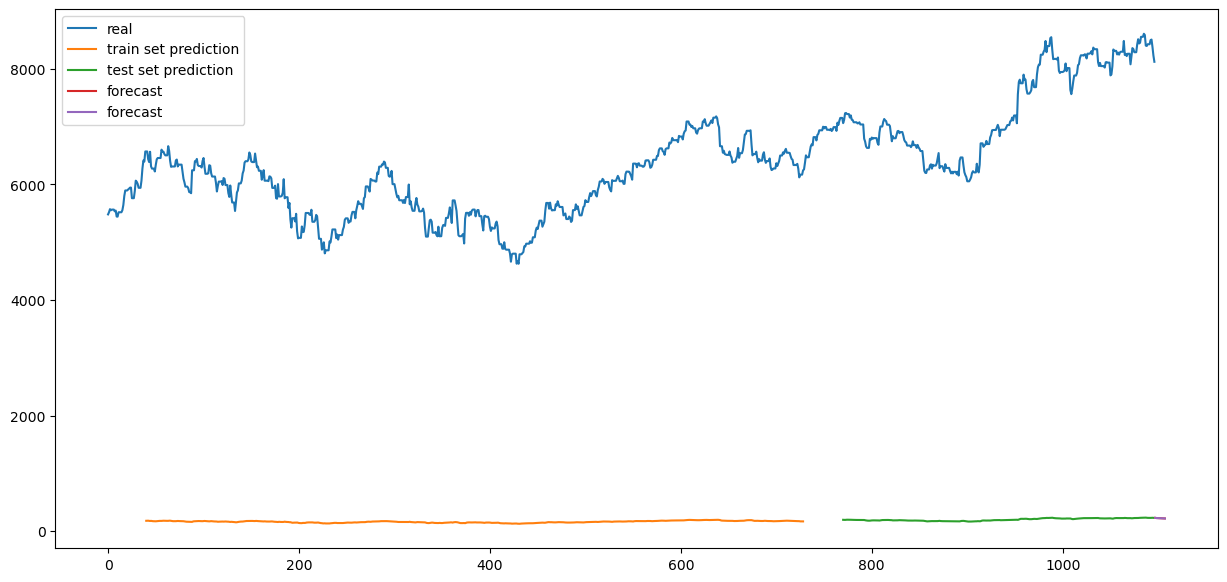

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2518 - learning_rate: 0.0010
Epoch 2/100
 25/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0280

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0264 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0221 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0162 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0131 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0135 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0116 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0103 - learning_ra

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0407 - learning_rate: 0.0010
Epoch 2/100
 25/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0162

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0133 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0105 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0093 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0082 - learning_ra

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0504 - learning_rate: 0.0010
Epoch 2/100
 27/173 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0176 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0121 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0101 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - learning_ra

In [35]:
#@title Test the Final Model (on AAPL)

num_runs = 5
mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], [], []

for i in range(num_runs):
    if i == 1:
        testScore_MSE, testScore_RMSE, testScore_MAE, testScore_MAPE, testScore_R2 = LSTM_model_final(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=True)
    else:
        testScore_MSE, testScore_RMSE, testScore_MAE, testScore_MAPE, testScore_R2 = LSTM_model_final(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=False)
    mse_scores.append(testScore_MSE)
    rmse_scores.append(testScore_RMSE)
    mae_scores.append(testScore_MAE)
    mape_scores.append(testScore_MAPE)
    r2_scores.append(testScore_R2)

avg_mse = np.mean(mse_scores)
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_mape = np.mean(mape_scores)
avg_r2 = np.mean(r2_scores)
print("Average results for $AAPL:")
print(f'Average MSE: {avg_mse:.2f}')
print(f'Average RMSE: {avg_rmse:.2f}')
print(f'Average MAE: {avg_mae:.2f}')
print(f'Average MAPE: {avg_mape:.2f}')
print(f'Average R²: {avg_r2:.2f}')

Symbols: ['LEG', 'OMC', 'IBM', 'CLX', 'ETR', 'CVX', 'ITW', 'PPG', 'ADSK', 'OKE']
Model for Symbol: LEG
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0267 - learning_rate: 0.0010
Epoch 2/100
 23/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0054 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - learning_ra

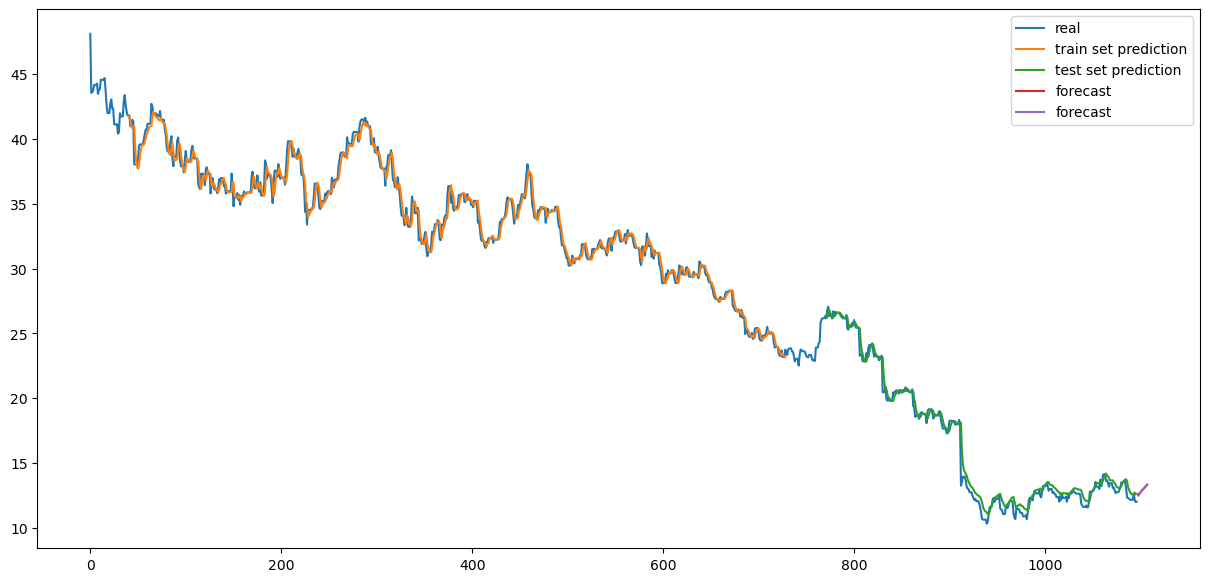

Model for Symbol: OMC
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0665 - learning_rate: 0.0010
Epoch 2/100
 14/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0131 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0125 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0130 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0116 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - learning_ra

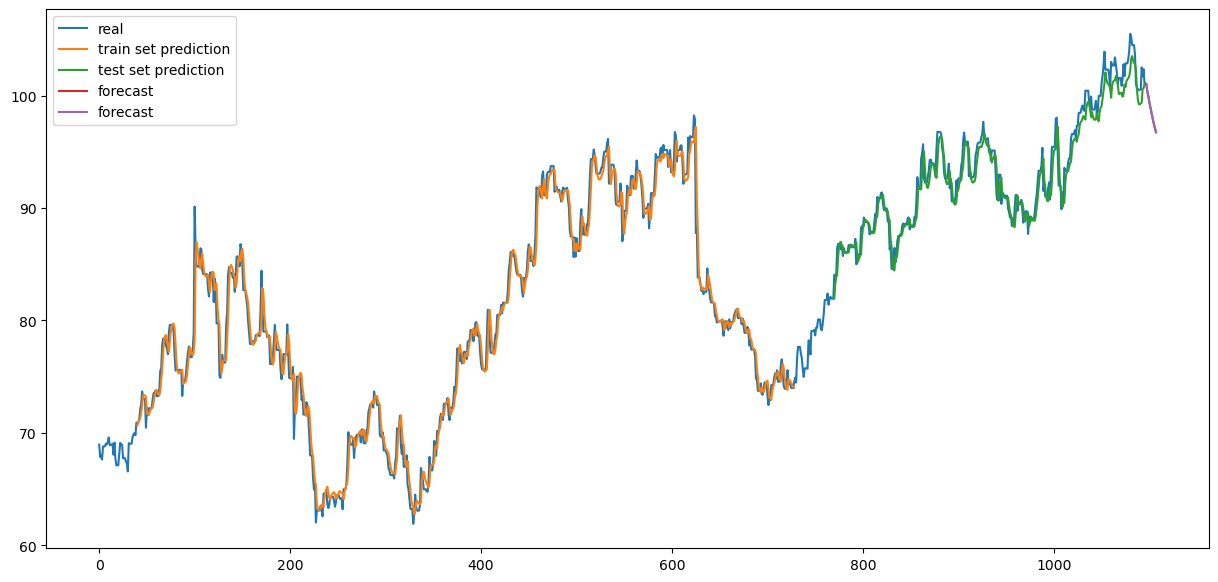

Model for Symbol: IBM
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0667 - learning_rate: 0.0010
Epoch 2/100
 22/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0284

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0236 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0194 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0168 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0148 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0150 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - learning_ra

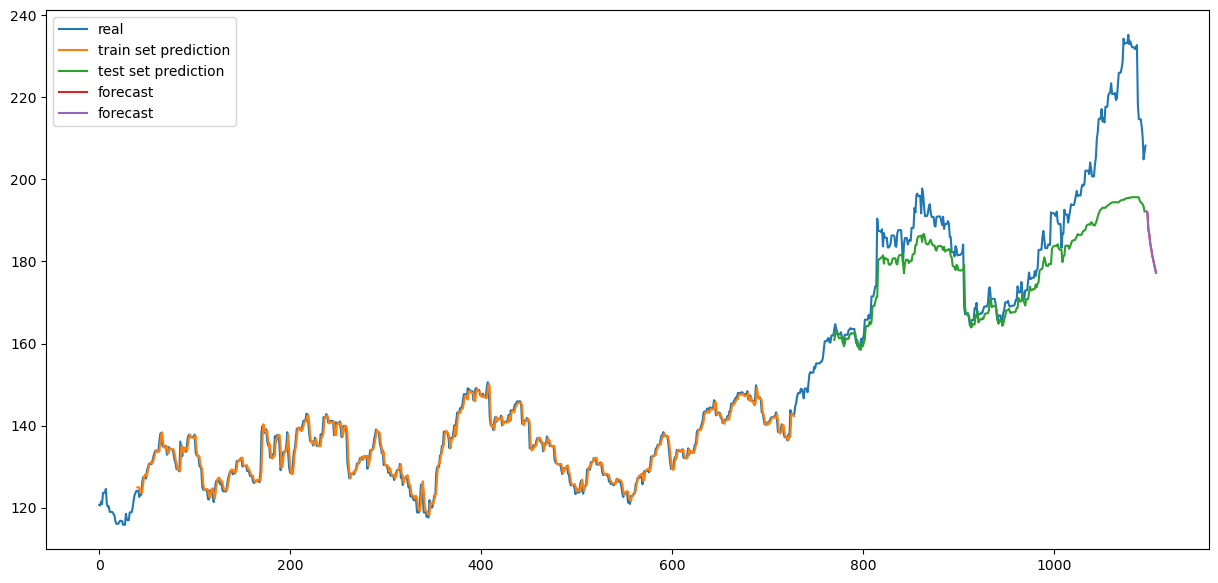

Model for Symbol: CLX
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1351 - learning_rate: 0.0010
Epoch 2/100
 25/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0273

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0248 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0186 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0160 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0095 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0104 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0133 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0115 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - learning_ra

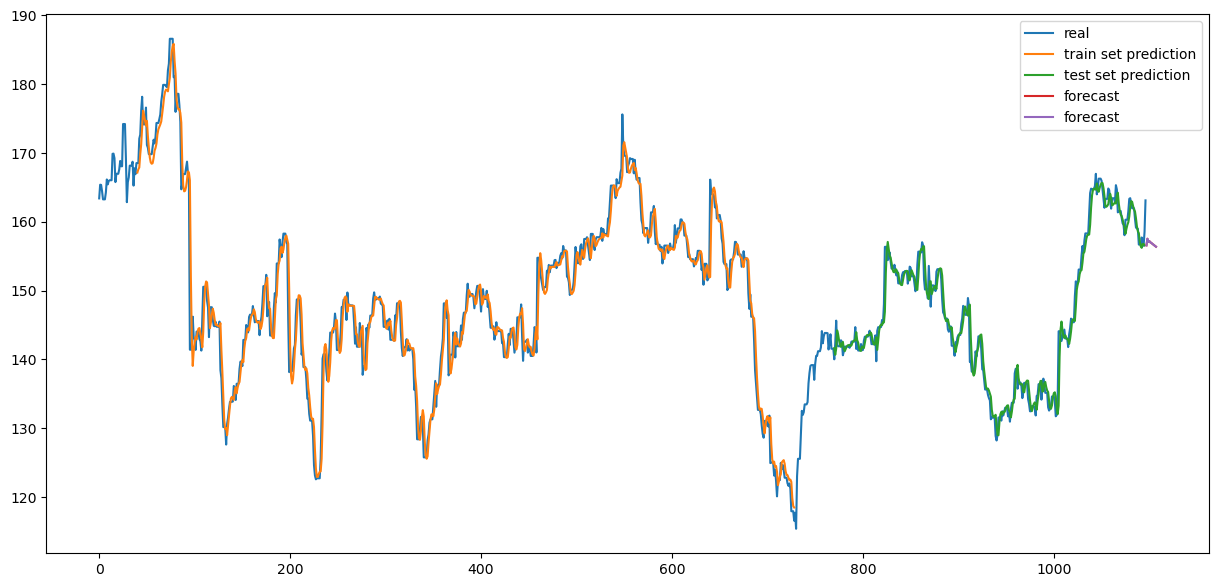

Model for Symbol: ETR
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0732 - learning_rate: 0.0010
Epoch 2/100
  9/173 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0316

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0192 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0127 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0109 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0104 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0085 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0079 - learning_ra

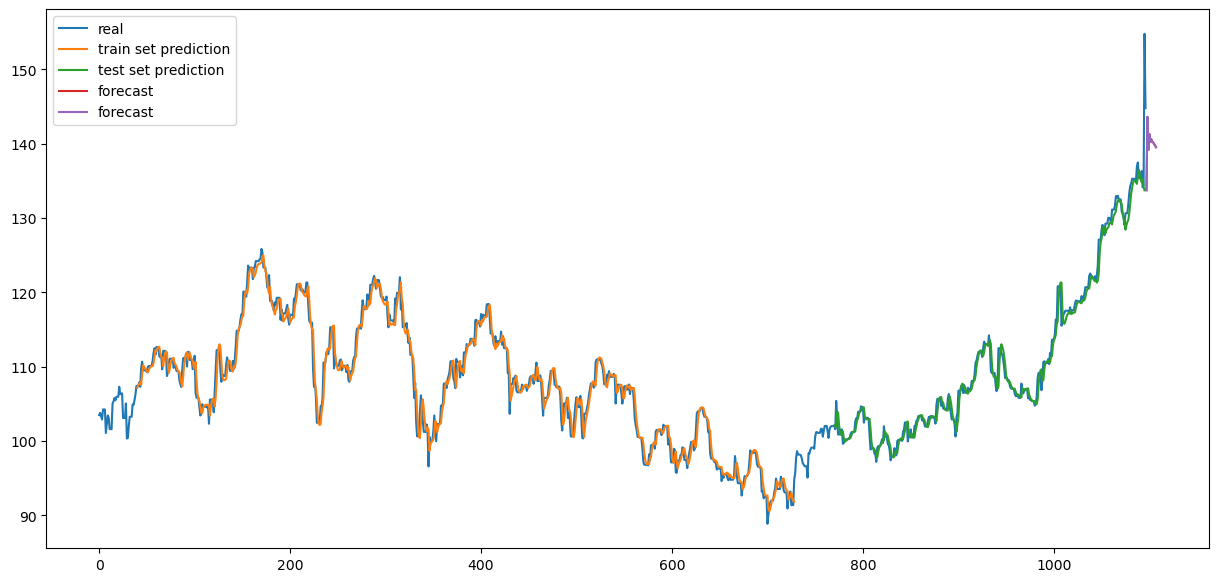

Model for Symbol: CVX
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0809 - learning_rate: 0.0010
Epoch 2/100
 24/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0128 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0121 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0082 - learning_ra

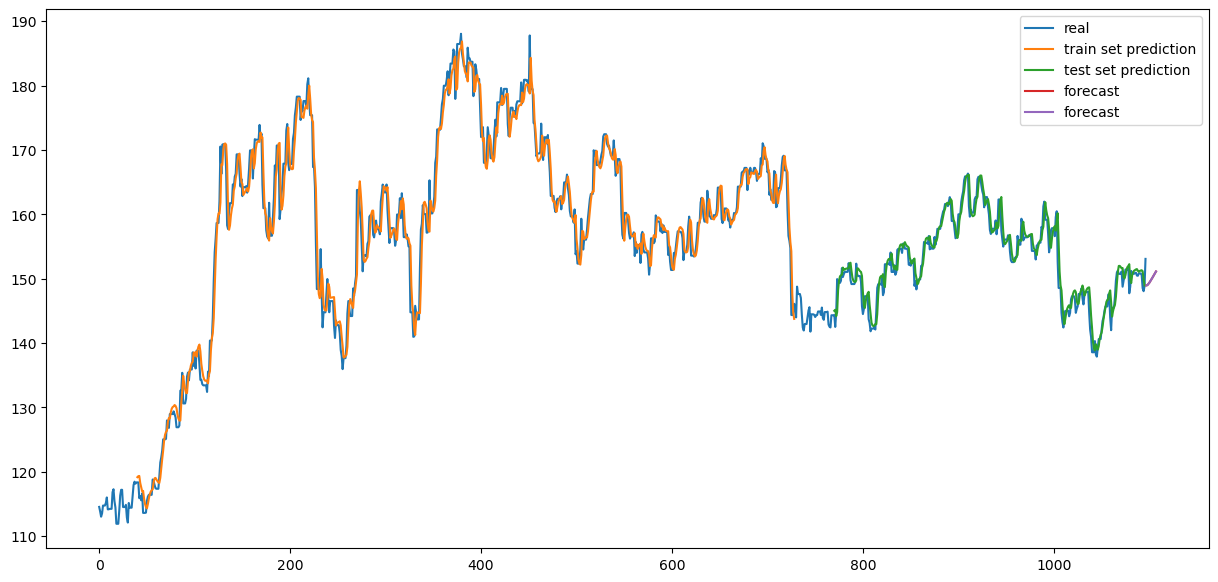

Model for Symbol: ITW
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0374 - learning_rate: 0.0010
Epoch 2/100
 23/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0158

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0156 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0128 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0111 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0088 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0078 - learning_r

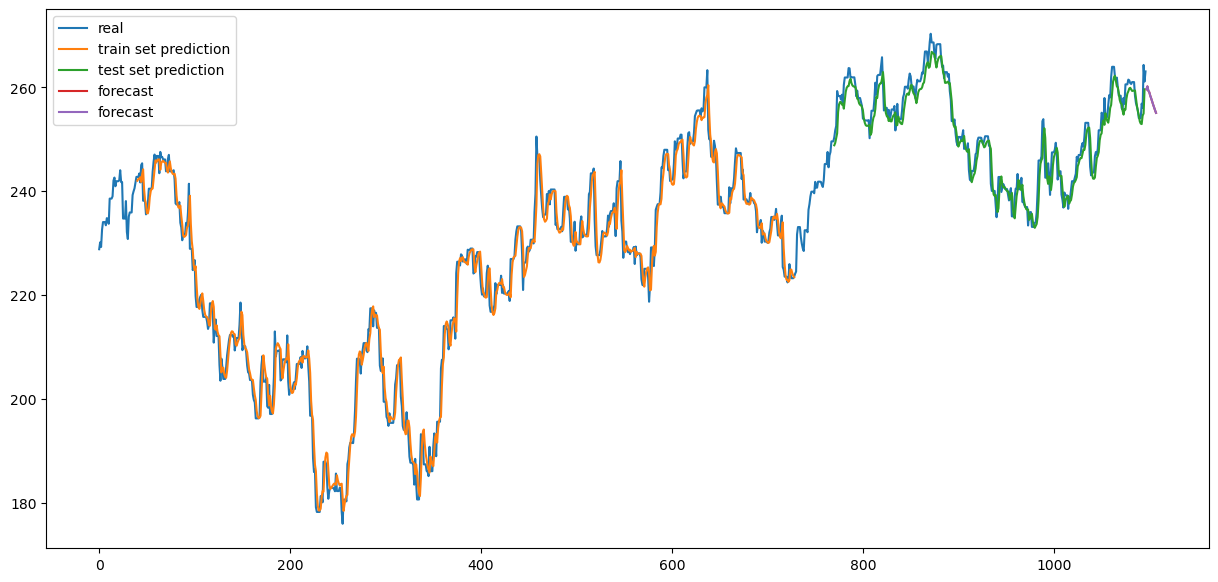

Model for Symbol: PPG
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1054 - learning_rate: 0.0010
Epoch 2/100
 23/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0200

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0201 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0141 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0115 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0124 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0104 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0081 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0084 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0087 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0072 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0089 - lea

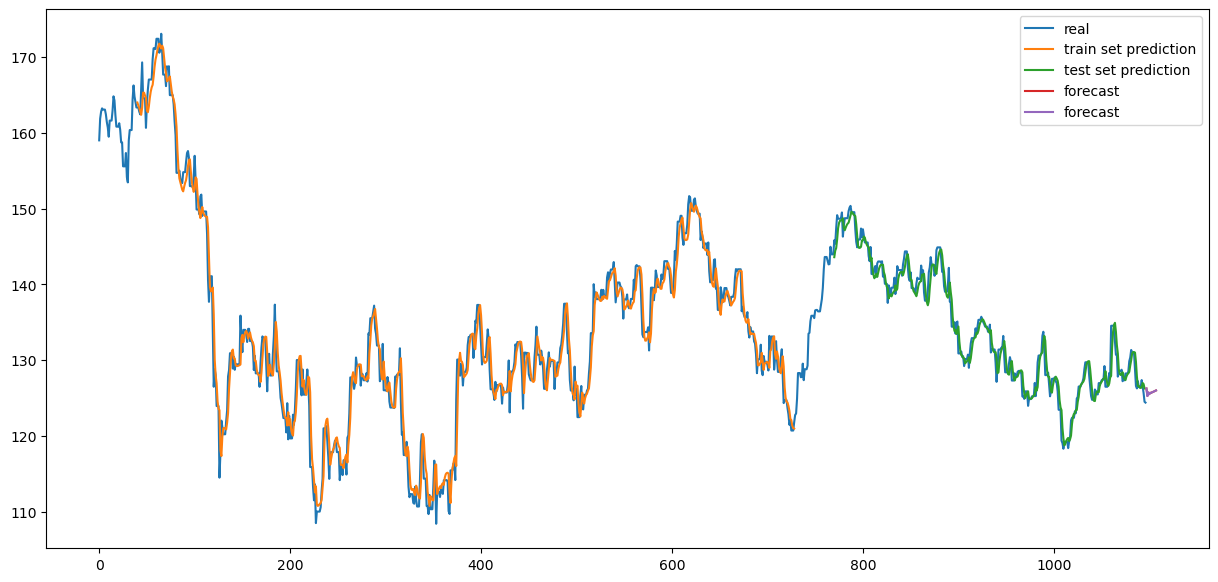

Model for Symbol: ADSK
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0536 - learning_rate: 0.0010
Epoch 2/100
 23/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0111 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0075 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0079 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - learning_ra

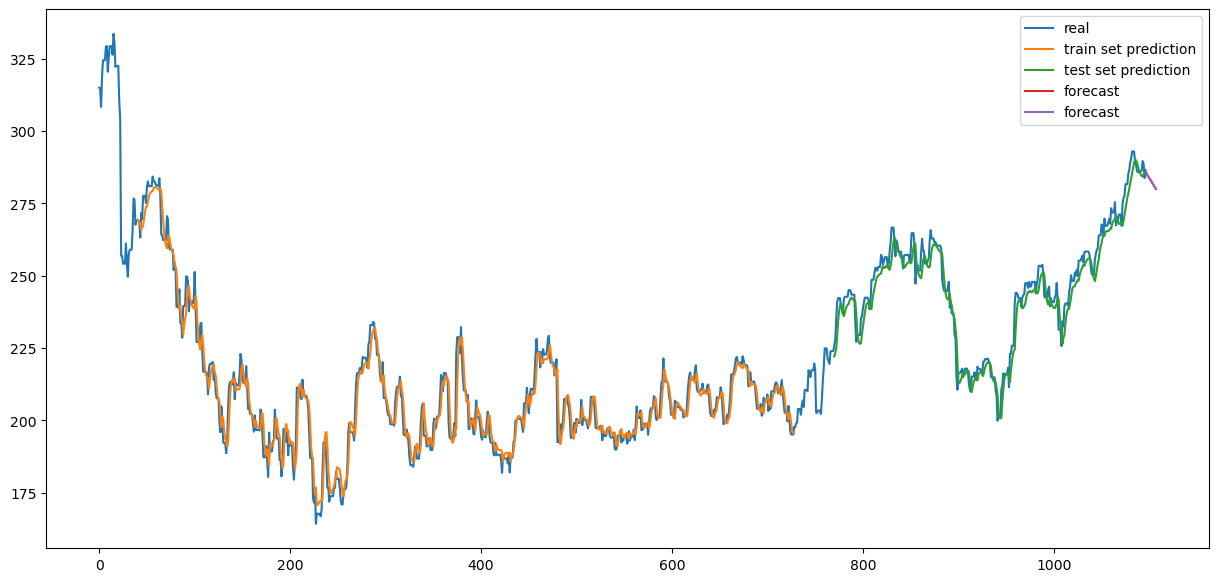

Model for Symbol: OKE
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0371 - learning_rate: 0.0010
Epoch 2/100
 24/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0365

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0222 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0152 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170 - learning_rate: 0.0010
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0131 - learning_rate: 0.0010
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0119 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0103 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - learning_rate: 0.0010
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0106 - learning_rate: 5.0000e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113 - learning_rate: 5.0000e-04
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0110 - learning_ra

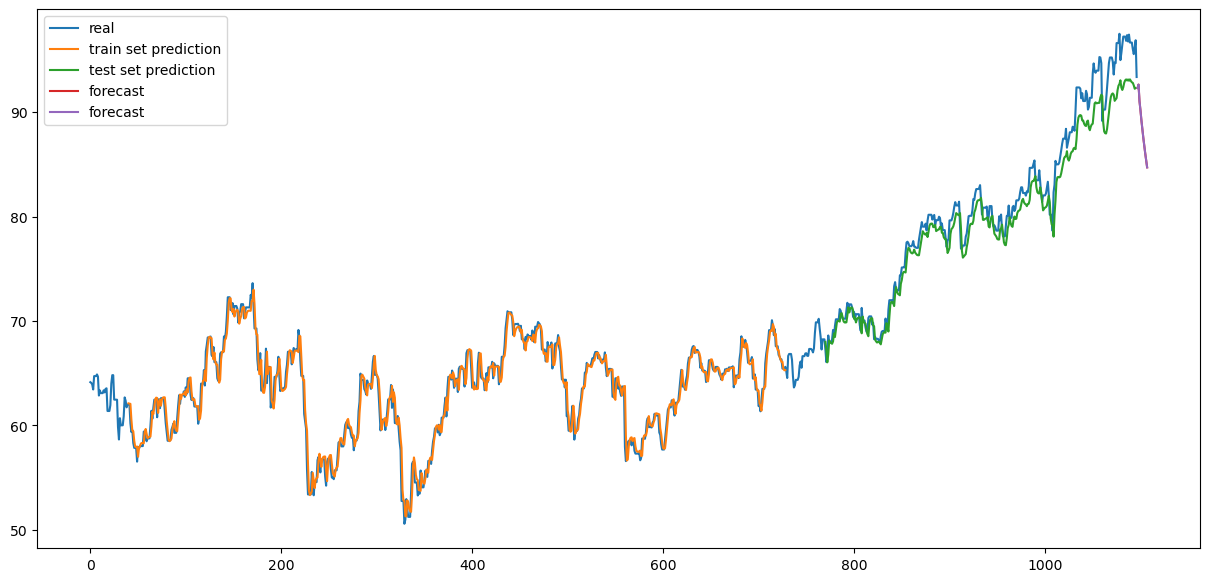

In [47]:
#@title Test in Different Symbols

data = pd.read_csv('/Users/pedroalexleite/Desktop/Tese/Dados/dataset4.csv')
unique_symbols = data["Symbol"].unique()
random_symbols = random.sample(list(unique_symbols), 10)
print("Symbols:", random_symbols)

for symbol in random_symbols:
    print("Model for Symbol:", symbol)
    scaler, data, train, test = read_prepare_data(symbol)
    LSTM_model_final(data, train, test, look_back=40, nepochs=100, horizon=10, plot_predictions=True)